In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import torch

from transformers import AutoTokenizer,AutoModelForSequenceClassification, Trainer,TrainingArguments
from datasets import Dataset,DatasetDict
from sklearn.model_selection import train_test_split

Dataset source: https://www.kaggle.com/datasets/abdelmalekeladjelet/sentiment-analysis-dataset/data

### First Look

In [2]:
df = pd.read_csv('sentiment_data.csv',index_col=0)
id2label = {0:'Negative',1:'Neutral',2:'Positive'}
label2id = {v:k for k,v in id2label.items()}

In [3]:
df

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2
...,...,...
241921,crores paid neerav modi recovered congress lea...,0
241922,dear rss terrorist payal gawar modi killing pl...,0
241923,cover interaction forum left,1
241924,big project came india modi dream project happ...,1


In [4]:
df.columns = ['text','label']
df['label_str'] = df.label.apply(lambda x: id2label[x])

In [5]:
df.isnull().sum()

text         217
label          0
label_str      0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
#converting emojis to text and removing some samples with weird text

import emoji

def preprocess_text(x):
    x = emoji.demojize(x).replace('♡',' heart ')
    
    non_ascci_count=0
    for c in x:
        non_ascci_count = non_ascci_count + 1 if ord(c) > 127 else non_ascci_count - 1
    if non_ascci_count >= 0:
        return ""
    
    x = re.sub(r'[\_\-\:]',' ',x)
    x = unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
    return re.sub(r'\s+',' ',x).lower().strip()


In [8]:
df['cleaned_text'] = df.text.apply(preprocess_text)

In [9]:
emoji_count = df.text.apply( lambda x: emoji.emoji_count(x) )

In [ ]:
df.loc[ (emoji_count > 0) & (df.text.str.len() <10 ) ].sample(10)

,text,label,label_str,cleaned_text
77533,👍,1,Neutral,thumbs up
67757,👍,2,Positive,thumbs up
67813,cute😍,1,Neutral,cute smiling face with heart eyes
74057,👍👍😎😎😎,2,Positive,thumbs up thumbs up smiling face with sunglass...
53522,good 👍,2,Positive,good thumbs up
76625,bad👎👎👎,0,Negative,bad thumbs down thumbs down thumbs down
71895,😀,1,Neutral,grinning face
64383,house👩🏾,2,Positive,house woman medium dark skin tone
70509,😶😶😶😶,0,Negative,face without mouth face without mouth face wit...
68861,love it🌠,2,Positive,love it shooting star


In [11]:
df.loc[df.cleaned_text.str.len() == 0]

,text,label,label_str,cleaned_text
32,liquid nitrogen ഇതുവരെ തീർന്നില്ലേ മച്ചാനെ,1,Neutral,
35,കേരളത്തിൽ ആദ്യമായി പെട്രോളിനെ എയ്സ് ആക്കിയ മച്...,1,Neutral,
38,തന്നെ തളർത്താൻ നോക്കിയവർ പോലും അവന്റെ ഉയർച്ചയി...,1,Neutral,
39,എത്ര എടുത്താലും തീരാത്ത liquid nitrogen,1,Neutral,
653,पत्रकार को बहुत जल्दी पता चलता है कि कहाँ है ज...,1,Neutral,
...,...,...,...,...
232156,modi looses country win à³à²¿ à³à³ à³ à³à...,2,Positive,
234272,watch live à¥à¤à¥à¥à¥à¤¾,2,Positive,
235959,indian national congress nationalist congress ...,1,Neutral,
236109,icj working overtime sundays modi trying achie...,1,Neutral,


In [12]:
df.cleaned_text.duplicated(keep='last').sum(),df.text.duplicated(keep='last').sum(),df.cleaned_text.loc[df.cleaned_text.str.len() > 0].duplicated(keep='last').sum()

(np.int64(27193), np.int64(26771), np.int64(26792))

In [13]:
df.loc[df.cleaned_text.str.len() > 0].drop_duplicates(subset='cleaned_text',keep='last')

,text,label,label_str,cleaned_text
0,lets forget apple pay required brand new iphon...,1,Neutral,lets forget apple pay required brand new iphon...
1,nz retailers don’t even contactless credit car...,0,Negative,nz retailers dont even contactless credit card...
2,forever acknowledge channel help lessons ideas...,2,Positive,forever acknowledge channel help lessons ideas...
3,whenever go place doesn’t take apple pay doesn...,0,Negative,whenever go place doesnt take apple pay doesnt...
4,apple pay convenient secure easy use used kore...,2,Positive,apple pay convenient secure easy use used kore...
...,...,...,...,...
241921,crores paid neerav modi recovered congress lea...,0,Negative,crores paid neerav modi recovered congress lea...
241922,dear rss terrorist payal gawar modi killing pl...,0,Negative,dear rss terrorist payal gawar modi killing pl...
241923,cover interaction forum left,1,Neutral,cover interaction forum left
241924,big project came india modi dream project happ...,1,Neutral,big project came india modi dream project happ...


In [14]:
df = df.loc[df.cleaned_text.str.len() > 0].drop_duplicates(subset='cleaned_text',keep='last')
len(df)

213734

In [15]:
df.isnull().sum()

text            0
label           0
label_str       0
cleaned_text    0
dtype: int64

### Data visualization

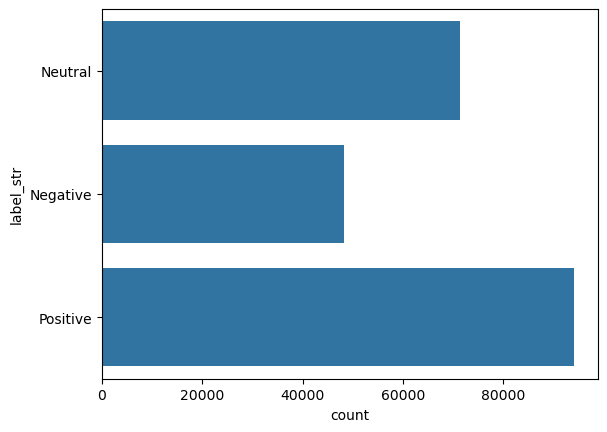

In [16]:
sns.countplot(y=df.label_str)
plt.show()

In [17]:
#Balancing the dataset for simplification
balanced_df = pd.concat( [ df.loc[df.label == l].sample(df.label.value_counts().min()) for l in df.label.unique()  ]   )
balanced_df = balanced_df.sample(len(balanced_df))
balanced_df.label.value_counts()

label
2    48233
0    48233
1    48233
Name: count, dtype: int64

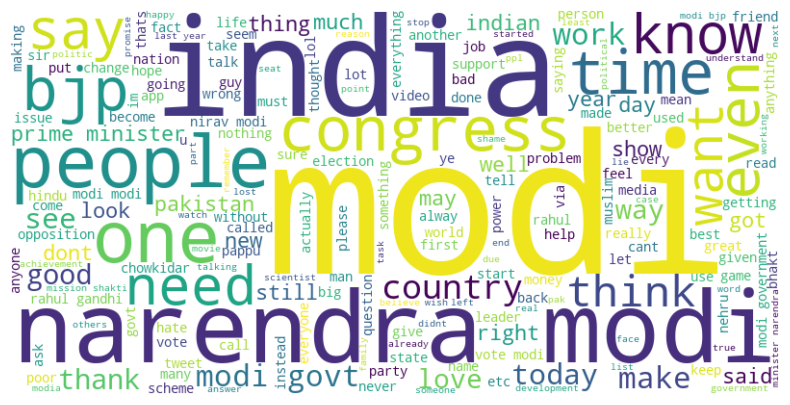

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join([str(v) for v in balanced_df.cleaned_text]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # Hide axes
plt.show()

In [19]:
import spacy
neg_words = {"no", "not", "n't", "never", "none", "nobody", "nothing",
    "neither", "nowhere", "cannot", "can't", "don't", "won't",
    "didn't", "isn't", "aren't", "wasn't", "weren't", "wouldn't",
    "shouldn't", "couldn't", "doesn't", "haven't", "hasn't", "hadn't"}

nlp = spacy.load('en_core_web_sm',disable=["ner", "parser", "textcat"])
def count_noun_and_adj(doc):
    noun_count = 0
    adj_count = 0
    neg_count = 0
    for token in doc:
        if token.pos_ == 'NOUN':
            noun_count += 1
        elif token.pos_ == 'ADJ':
            adj_count += 1
        elif token.text in neg_words:
            neg_count += 1
    return [noun_count,adj_count,neg_count]

docs = list(nlp.pipe(balanced_df.cleaned_text, batch_size=256, n_process=-1))
balanced_df[ ['Noun_Counts','Adj_Counts','Neg_Counts'] ] = [ pd.Series(count_noun_and_adj(doc)) for doc in docs ]

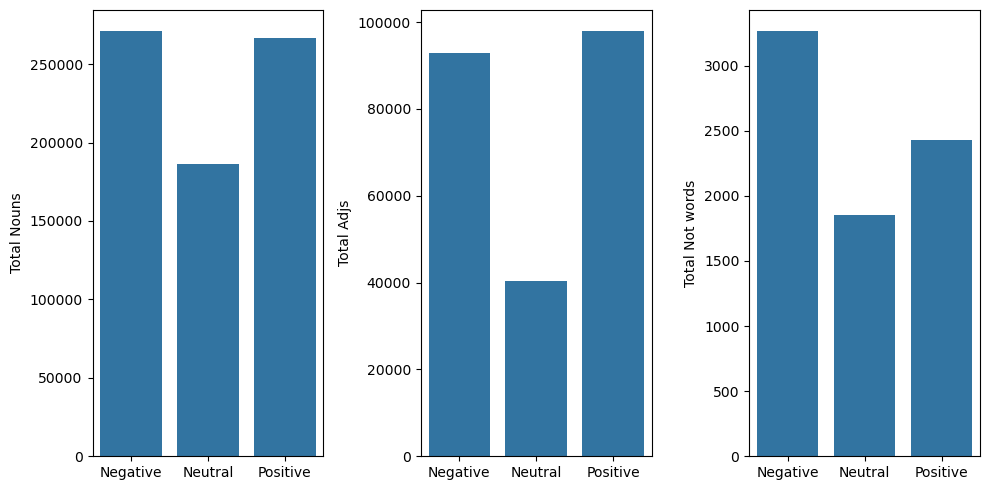

In [20]:
sentiment_group = balanced_df.groupby('label_str')

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.barplot(x = [i for i in sentiment_group.Noun_Counts.sum().index]  , y =  sentiment_group.Noun_Counts.sum().values)
plt.ylabel('Total Nouns')
plt.subplot(1,3,2)
sns.barplot(x = [i for i in sentiment_group.Adj_Counts.sum().index] , y =  sentiment_group.Adj_Counts.sum().values)
plt.ylabel('Total Adjs')
plt.subplot(1,3,3)
sns.barplot(x = [i for i in sentiment_group.Neg_Counts.sum().index] , y =  sentiment_group.Neg_Counts.sum().values)
plt.ylabel('Total Not words')
plt.tight_layout()
plt.show()

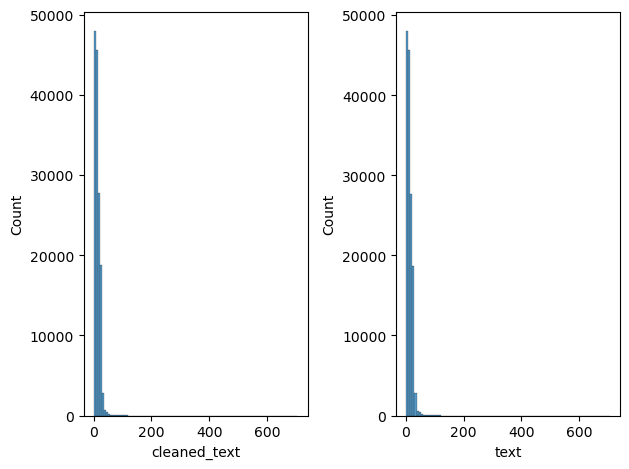

In [21]:
len_clened_text = balanced_df.cleaned_text.apply(lambda x: len(x.split()))
len_text = balanced_df.text.apply(lambda x: len(x.split()))

plt.subplot(1,2,1)
sns.histplot(x=len_clened_text,bins=100)
plt.subplot(1,2,2)
sns.histplot(len_text,bins=100)
plt.tight_layout()
plt.show()

### Training

In [22]:
text_column = 'cleaned_text'

train_df,test_df = train_test_split(balanced_df[ [text_column,'label'] ],test_size=0.3,stratify=balanced_df.label)
test_df,val_df = train_test_split(test_df,test_size=1/3,stratify=test_df.label)

In [23]:
dataset = DatasetDict({
    'train':Dataset.from_pandas(train_df,preserve_index=False),
    'test':Dataset.from_pandas(test_df,preserve_index=False),
    'validation':Dataset.from_pandas(val_df,preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['cleaned_text', 'label'],
        num_rows: 101289
    })
    test: Dataset({
        features: ['cleaned_text', 'label'],
        num_rows: 28940
    })
    validation: Dataset({
        features: ['cleaned_text', 'label'],
        num_rows: 14470
    })
})

In [24]:
model_id = 'distilbert/distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id
).to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#tokenizing with max len of 100 for simplification and faster training
def tokenize(batch):
    return tokenizer(batch[text_column],padding=True,truncation=True,return_tensors='pt',max_length=100)

dataset = dataset.map(tokenize,batched=True,batch_size=4096)
dataset

Map:   0%|          | 0/101289 [00:00<?, ? examples/s]

Map:   0%|          | 0/28940 [00:00<?, ? examples/s]

Map:   0%|          | 0/14470 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 101289
    })
    test: Dataset({
        features: ['cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 28940
    })
    validation: Dataset({
        features: ['cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 14470
    })
})

In [26]:
#max( len(i) for i in dataset['train']['input_ids'] ),max( len(i) for i in dataset['test']['input_ids'] ),max( len(i) for i in dataset['validation']['input_ids'] )

In [ ]:
batch_size = 32 #used 2.6Gb of gpu memory 
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(output_dir='training_dir',
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                auto_find_batch_size=True,
                                weight_decay=0.01,
                                eval_strategy='epoch',
                                save_strategy='epoch',
                                gradient_accumulation_steps=2,
                                load_best_model_at_end=True,
                                metric_for_best_model='accuracy')

trainer = Trainer(args=training_args,
                    model=model,
                    compute_metrics=compute_metrics,
                    train_dataset=dataset['train'],
                    eval_dataset=dataset['validation'],
                    processing_class=tokenizer
            )

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487200,0.448118,0.840221,0.840225
2,0.396200,0.421492,0.850657,0.850401
3,0.353700,0.409613,0.855218,0.855243


TrainOutput(global_step=4749, training_loss=0.44292862828492263, metrics={'train_runtime': 1752.0835, 'train_samples_per_second': 173.432, 'train_steps_per_second': 2.71, 'total_flos': 7861950951773400.0, 'train_loss': 0.44292862828492263, 'epoch': 3.0})

### Evaluating and saving

In [28]:
from sklearn.metrics import classification_report
y_true = dataset['test']['label']
y_preds = trainer.predict(dataset['test'])
print(classification_report(y_true,y_preds.predictions.argmax(-1)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      9646
           1       0.84      0.86      0.85      9647
           2       0.88      0.86      0.87      9647

    accuracy                           0.85     28940
   macro avg       0.85      0.85      0.85     28940
weighted avg       0.85      0.85      0.85     28940



In [29]:
def predict(data):
    inputs = tokenizer(data,padding=True,truncation=True,return_tensors='pt',max_length=50)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_ = model.to(device)
    inputs_ = {k:v.to(device) for k,v in inputs.items()}
    model_.eval()
    with torch.no_grad():
        preds = model_(**inputs_)['logits']
        preds = torch.argmax(preds,dim=1).cpu().numpy()
        str_preds = [ id2label[pred] for pred in preds ]
        return str_preds

In [31]:
predict(['Hello!',
           'it is a wonderful day!',
           'getting home now',
           'it is the worst app i ever used',
           'full of problems'])

['Neutral', 'Positive', 'Neutral', 'Negative', 'Negative']

In [32]:
trainer.save_model('ft-classifier')

In [33]:
from transformers import pipeline
pipe = pipeline('text-classification','ft-classifier')

Device set to use cuda:0


In [34]:
pipe(['it is a wonderful day!','getting home now','it is the worst app i ever used','full of problems'])

[{'label': 'Positive', 'score': 0.9919365644454956},
 {'label': 'Neutral', 'score': 0.9635529518127441},
 {'label': 'Negative', 'score': 0.9482904076576233},
 {'label': 'Negative', 'score': 0.5625277757644653}]